## Build a machine learning model to classify fraud and non-fraud transactions


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import scipy.stats as stats

%matplotlib inline

### Reading data from fraud csv file and observing features of Column.

In [2]:
fraud = pd.read_csv('Fraud.csv')
fraud.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [3]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


##### Checking unique values of two Column nameDest, nameOrig to get an idea if the fraud is done by same person or if fraudster target same person multiple times.

In [4]:
for i in ['nameDest', 'nameOrig']:
    print(len(fraud[i].unique()))

2722362
6353307


In [5]:
# checking for null values in data
print(fraud.isnull().sum())

# to check how many frauds happen
print(sum(fraud.isFraud))

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
8213


In [6]:
legit_transaction = len(fraud[fraud.isFraud == 0])
fraud_transaction = len(fraud[fraud.isFraud == 1])
legit_percent = (legit_transaction / (fraud_transaction + legit_transaction)) * 100
fraud_percent = (fraud_transaction / (fraud_transaction + legit_transaction)) * 100

print("Total Legit transactions: ", legit_transaction)
print("Total Fraud transactions: ", fraud_transaction)
print("Percentage of Legit transactions: {:.4f} %".format(legit_percent))
print("Percentage of Fraud transactions: {:.4f} %".format(fraud_percent))

Total Legit transactions:  6354407
Total Fraud transactions:  8213
Percentage of Legit transactions: 99.8709 %
Percentage of Fraud transactions: 0.1291 %


Dataset with no NULL values

This result shows that data is highly unbalanced as Percentage of Legit transactions= 99.87 % and Percentage of Fraud transactions= 0.13 %. SO DECISION TREES AND RANDOM FORESTS should be used as they give better accuracy with IMBALANCED DATA.

##### To check the mode of fraud by counting 0 and 1 corresponding to CASH_IN, CASH_OUT, DEBIT , PAYMENT, TRANSFER.

In [7]:
grouped_df = fraud.groupby(['type', 'isFraud']).size().unstack(fill_value=0)
print(grouped_df)

grouped_df1 = fraud.groupby(['type', 'isFlaggedFraud']).size().unstack(fill_value=0)
print(grouped_df1)


isFraud         0     1
type                   
CASH_IN   1399284     0
CASH_OUT  2233384  4116
DEBIT       41432     0
PAYMENT   2151495     0
TRANSFER   528812  4097
isFlaggedFraud        0   1
type                       
CASH_IN         1399284   0
CASH_OUT        2237500   0
DEBIT             41432   0
PAYMENT         2151495   0
TRANSFER         532893  16


 The current algorithm, has no flags during fraud transactions in case of cash_out , which goes against the anti money laundering system . Also there are only 16 transactions which are flagged as fraud which is much less compare actual numbers of fraud fraud i.e. 4k. We have to build an efficient algorithm to mitigate this risk of letting fraud transactions unblocked.

##### To analyse correlation between different columns of data

                  amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
amount          1.000000      -0.002762       -0.007861        0.294137   
oldbalanceOrg  -0.002762       1.000000        0.998803        0.066243   
newbalanceOrig -0.007861       0.998803        1.000000        0.067812   
oldbalanceDest  0.294137       0.066243        0.067812        1.000000   
newbalanceDest  0.459304       0.042029        0.041837        0.976569   

                newbalanceDest  
amount                0.459304  
oldbalanceOrg         0.042029  
newbalanceOrig        0.041837  
oldbalanceDest        0.976569  
newbalanceDest        1.000000  


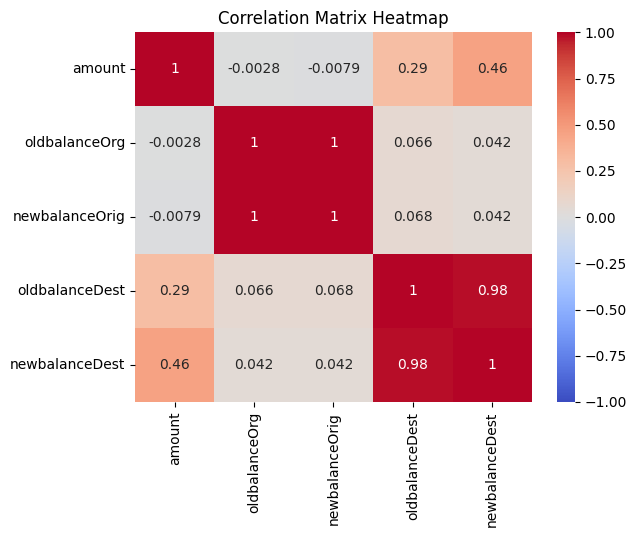

In [8]:
correlation_matrix = fraud[fraud.select_dtypes(include='float64').columns].corr()

print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

#####  Analysing multicollinearity in data by calculating Variance Inflation Factor(VIF) for each feature

In [9]:
#VIF = 1: No multicollinearity.
#1 < VIF < 5: Moderate multicollinearity.
#VIF > 5: High multicollinearity, which may need to be addressed.

X = fraud[fraud.select_dtypes(include='float64').columns].assign(Intercept=1)  # Add an intercept for VIF calculation
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          feature         VIF
0          amount    3.704164
1   oldbalanceOrg  430.052765
2  newbalanceOrig  431.093970
3  oldbalanceDest   64.982048
4  newbalanceDest   74.887727
5       Intercept    1.249912


In [10]:
X.columns

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'Intercept'],
      dtype='object')

In [11]:
# creating copy of original so that further action on data does not impact the original data
fraud1=fraud.copy()

In [12]:
obj = fraud1.select_dtypes(include = "object").columns
print (obj)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


THERE ARE 3 ATTRIBUTES WITH Object Datatype. THUS WE NEED TO LABEL ENCODE THEM IN ORDER TO CHECK MULTICOLINEARITY.

In [13]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder on the 'nameDest' column
fraud1['nameDest'] = label_encoder.fit_transform(fraud1['nameDest'])

print(fraud1['nameDest'])

0          1662094
1          1733924
2           439685
3           391696
4           828919
            ...   
6362615     505863
6362616     260949
6362617     108224
6362618     319713
6362619     534595
Name: nameDest, Length: 6362620, dtype: int64


In [14]:
data=[['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']]
encd=OrdinalEncoder(categories=data)
encd.fit(fraud1[['type']])
fraud1['type']=encd.transform(fraud1[['type']])

#####  1) As the columns were having high multicollinarity so creating new columns 'diffDist' and 'diffOrg' containing difference between values of 'oldbalanceDest'-'newbalanceDest' and  'oldbalanceOrg'-'newbalanceOrig'.
##### 2) Adding absolute of minimum+1 to each data in column to transform Negative/Zero into positive then using  Shift and Log Transformation, this approach shifts the entire distribution, to make data more normally distributed.

In [15]:
# adding absolute of minimum+1 to each data in column so as to transform zero and negative into positive data to suite the logrithmic transformation to make data more normally distributed
for i in ['oldbalanceDest','newbalanceDest','oldbalanceOrg','newbalanceOrig','amount']:
   shift_value = abs(fraud[i].min()) + 1
   fraud1[i] = np.log(fraud[i] + shift_value)



fraud1['diffDist']=fraud1['oldbalanceDest']-fraud1['newbalanceDest']
fraud1['diffOrg']=fraud1['oldbalanceOrg']-fraud1['newbalanceOrig']

# Dropping columns that are of no use in later stage of model development.
fraud1.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','nameOrig'],axis=1,inplace=True)

In [16]:
fraud1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            float64
 2   amount          float64
 3   nameDest        int64  
 4   isFraud         int64  
 5   isFlaggedFraud  int64  
 6   diffDist        float64
 7   diffOrg         float64
dtypes: float64(4), int64(4)
memory usage: 388.3 MB


#####  Checking if the above performed actions have reduced the multicollinearity in data.

In [17]:
X = fraud1[fraud1.select_dtypes(include='float64').columns].assign(Intercept=1)  # Add an intercept for VIF calculation
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

     feature        VIF
0       type   1.572588
1     amount   1.602907
2   diffDist   1.232674
3    diffOrg   1.385107
4  Intercept  45.535968


### Plotting data of three columns to get idea abut distribution of values and then using it to removing outliers.

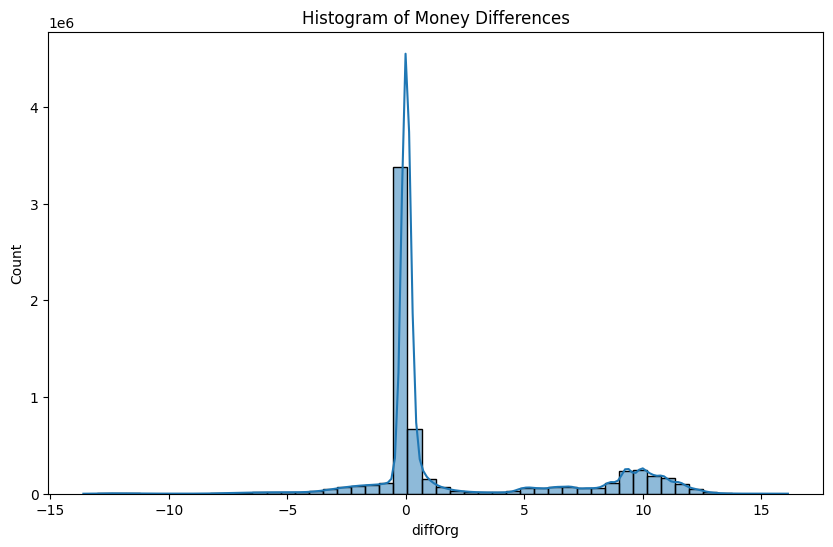

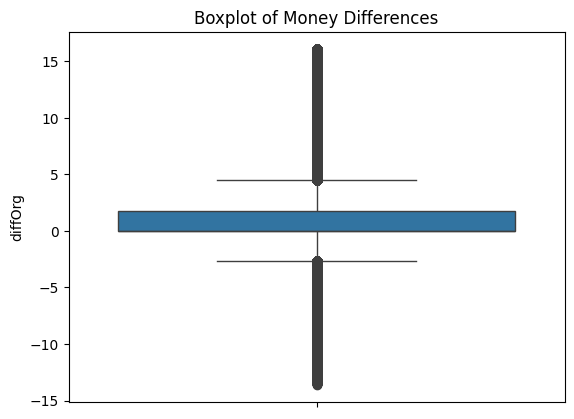

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud1['diffOrg'], bins=50, kde=True)
plt.title('Histogram of Money Differences')
plt.show()

sns.boxplot(fraud1['diffOrg'])
plt.title('Boxplot of Money Differences')
plt.show()

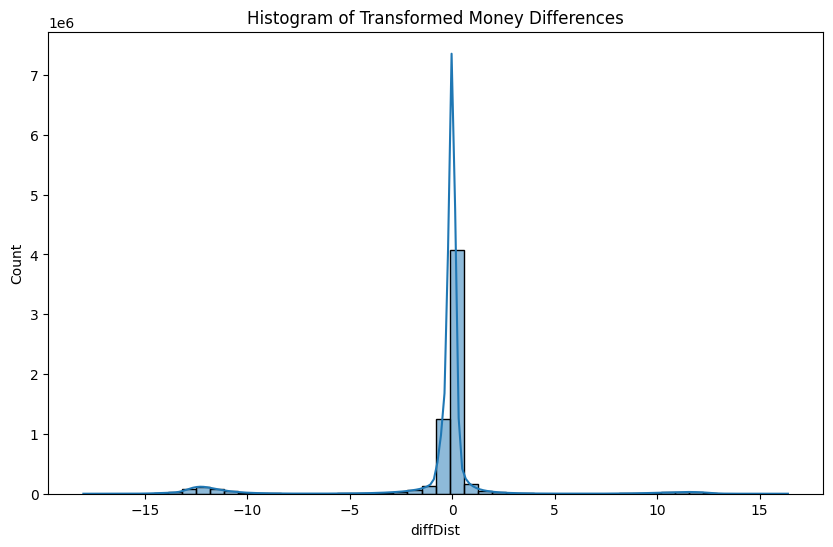

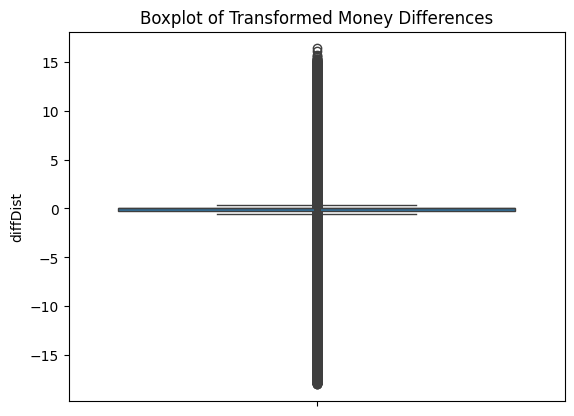

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud1['diffDist'], bins=50, kde=True)
plt.title('Histogram of Transformed Money Differences')
plt.show()

sns.boxplot(fraud1['diffDist'])
plt.title('Boxplot of Transformed Money Differences')
plt.show()

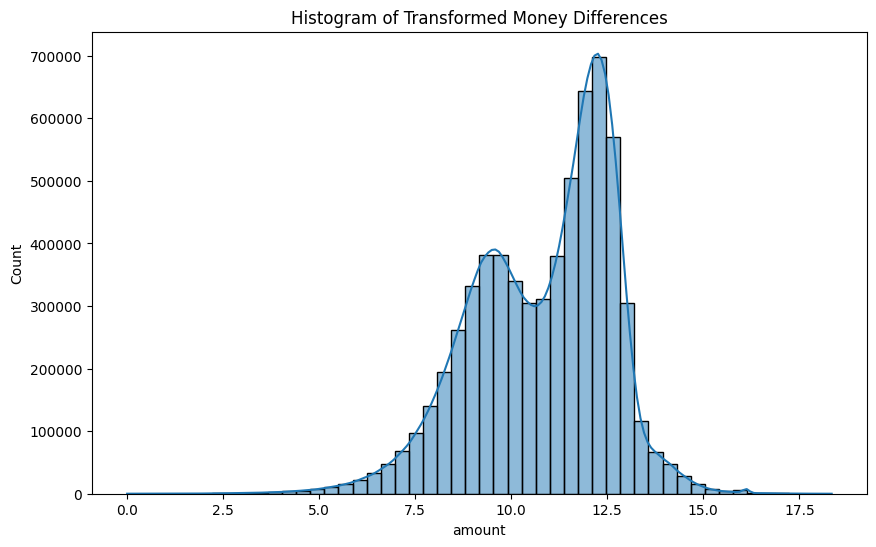

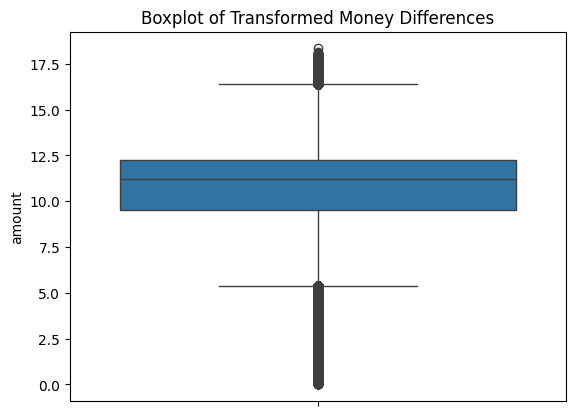

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud1['amount'], bins=50, kde=True)
plt.title('Histogram of Transformed Money Differences')
plt.show()

sns.boxplot(fraud1['amount'])
plt.title('Boxplot of Transformed Money Differences')
plt.show()

### To detect outliers in data

In [21]:
def detect_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[column_name][(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return outliers
    

for i in fraud1.select_dtypes(include='float64').columns:
        outliers = detect_outliers(fraud1, i)
        if len(outliers)>0:
             print(f"Number of Outliers in {i}:\n", len(outliers),'    ',100*len(outliers)/len(fraud),'%')
            



Number of Outliers in amount:
 32429      0.5096799746016578 %
Number of Outliers in diffDist:
 1432002      22.506483178313335 %
Number of Outliers in diffOrg:
 1687447      26.52126010982897 %


#### Removing the data which are abruptly outliers as the basic definition is showing nearly 50%, 22%, 26% outliers in 'amount', 'diffDist', 'diffOrg' so by the analysing above graph removing those values which are significantly high or low. 

In [22]:
save=fraud1.copy()
#for 'amount' column
Q1 = save['amount'].quantile(0.25)
Q3 = save['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
save= save[(save['amount'] >= lower_bound) & (save['amount'] <= upper_bound)]
    
print(lower_bound,upper_bound)
print(fraud.shape[0]-save.shape[0])





#for 'diffDist' column
'''Q1 = save['diffDist'].quantile(0.1)  # lots of data was lost as many values are outliers so manually limiting scope of values
Q3 = save['diffDist'].quantile(0.90)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound,upper_bound)'''

save= save[(save['diffDist'] >= -13) & (save['diffDist'] <= 5)]
print(fraud.shape[0]-save.shape[0])






#for 'diffOrg' column
Q1 = save['diffOrg'].quantile(0.2)
Q3 = save['diffOrg'].quantile(0.8)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
save= save[(save['diffOrg'] >= lower_bound) & (save['diffOrg'] <= upper_bound)]

print(lower_bound,upper_bound)
print(fraud.shape[0]-save.shape[0])



5.3826238325872495 16.368442963982808
32429
210144
-10.056517796474173 16.75311122214319
222398


In [23]:
save.head()

,step,type,amount,nameDest,isFraud,isFlaggedFraud,diffDist,diffOrg
0,1,0.0,9.194276,1662094,0,0,0.0,0.059573
1,1,0.0,7.531166,1733924,0,0,0.0,0.091820
4,1,0.0,9.364703,828919,0,0,0.0,0.329599
5,1,0.0,8.964275,2247218,0,0,0.0,0.156825
6,1,0.0,8.869085,2063363,0,0,0.0,0.039571


In [24]:
save.drop(['step','isFlaggedFraud'],axis=1,inplace=True)
save.head()

,type,amount,nameDest,isFraud,diffDist,diffOrg
0,0.0,9.194276,1662094,0,0.0,0.059573
1,0.0,7.531166,1733924,0,0.0,0.091820
4,0.0,9.364703,828919,0,0.0,0.329599
5,0.0,8.964275,2247218,0,0.0,0.156825
6,0.0,8.869085,2063363,0,0.0,0.039571


In [25]:
#Splitting dependent and independent variable
X=save.drop('isFraud',axis=1)
y=save['isFraud']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=111)


In [26]:
#Standardizing the numerical columns
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

In [27]:
logreg_cv = LogisticRegression(solver='liblinear',random_state=22)
dt_cv=DecisionTreeClassifier(random_state=22)
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree'}
cv_models=[logreg_cv,dt_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X_train, y_train, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9989942196033598
Decision Tree Test Accuracy: 0.9997038264095085


In [33]:
dt_cv.fit(X_train, y_train)
Y_pred_rf = dt_cv.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, Y_pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

True Positives: 1505
False Positives: 225
True Negatives: 1839572
False Negatives: 765


In [35]:
random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, y_train)

Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, y_test) * 100

print("Random Forest Score: ", random_forest_score)
#unable to run as algorithm taking too much time

Random Forest Score:  99.94555029757333


In [36]:
tn, fp, fn, tp = confusion_matrix(y_test, Y_pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

True Positives: 1302
False Positives: 35
True Negatives: 1839762
False Negatives: 968


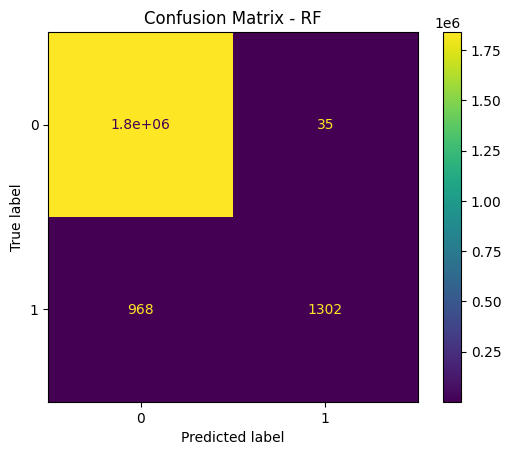

In [41]:
confusion_matrix_rf = confusion_matrix(y_test, Y_pred_rf.round())
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show()

Using Random Forest and Decision Tree  algorithm because the dataset provided was highly unbalanced. Although the overall accuracy of decision tree is greater than random forest but random forest is more accurate in predicting frauds i.e. less False Positives: 35 compared to 225 for decision tree.
